#  Text Classification - Sentiment Analysis
## Comparative Study of Various Numerical Representations of Text

***

In [23]:
# imports 
import pandas as pd
import numpy as np
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pprint

***

## Labelled Tweets - Text Corpus


In [2]:
tweets = pd.read_csv('tweets.csv')
tweets.head()

,sentiment,text,selected_text
0,positive,so great to see oin &amp; cynthia. so happy. ...,so great to see oin &amp; cynthia. so happy.
1,positive,bought a new combo printer at costco today (of...,cheaper than ink 4 old one. #windows7 doesn't...
2,positive,freedom,freedom
3,negative,its funny. i'm kinda sad on my last day,sad
4,positive,@_bella_cullen13 @rosaliehcullen @esme_cullen2...,girls love


In [3]:
tweets.shape

(8493, 3)

In [4]:
tweet_text = tweets['text']
tweet_text.head()

0    so great to see oin &amp; cynthia.  so happy. ...
1    bought a new combo printer at costco today (of...
2                                              freedom
3              its funny. i'm kinda sad on my last day
4    @_bella_cullen13 @rosaliehcullen @esme_cullen2...
Name: text, dtype: object

### Label Encoding 

In [5]:
# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
tweets['sentiment_le'] = labelencoder.fit_transform(tweets['sentiment'])

tweets.head()

,sentiment,text,selected_text,sentiment_le
0,positive,so great to see oin &amp; cynthia. so happy. ...,so great to see oin &amp; cynthia. so happy.,2
1,positive,bought a new combo printer at costco today (of...,cheaper than ink 4 old one. #windows7 doesn't...,2
2,positive,freedom,freedom,2
3,negative,its funny. i'm kinda sad on my last day,sad,0
4,positive,@_bella_cullen13 @rosaliehcullen @esme_cullen2...,girls love,2


In [6]:
tweet_sentiment_labels = tweets['sentiment_le']
tweet_sentiment_labels.head()

0    2
1    2
2    2
3    0
4    2
Name: sentiment_le, dtype: int64

***

## 1/ Bag of Words Approach (using SpaCy)

### Setup spacy enlish vocab based model

In [7]:
# create empty model
nlp = spacy.blank("en")

# create the `textcategorizer` pipe with the given parameter settings
textcat = nlp.create_pipe(
    "textcat", # internal name of the pipe
    config={
        "exclusive_classes": True, # set "exclusive_classes" parameter to "True" (spam or ham output based on input - i.e. discrete classification output of input text)
        "architecture": "bow", # set the pipe "architecture" parameter to "bow" (bag-of-words model)
    }
)

# add the newly created pipe to the blank nlp model
nlp.add_pipe(textcat)

### SpaCy labels

In [8]:
# Add labels to text classifier
textcat.add_label("positive")
textcat.add_label("neutral")
textcat.add_label("negative")

1

### Extract input texts

In [9]:
X_bow = tweets['text']
print(X_bow)

0       so great to see oin &amp; cynthia.  so happy. ...
1       bought a new combo printer at costco today (of...
2                                                 freedom
3                 its funny. i'm kinda sad on my last day
4       @_bella_cullen13 @rosaliehcullen @esme_cullen2...
                              ...                        
8488    auto uit de running... one down, one yet to build
8489    9:30pm and this grandma is going to sleep.  20...
8490    aaauuuggghhh! in n out, check! mcdonald's, che...
8491                scratch that; sleep on a stage bound.
8492                     wishes she was in boston for dmb
Name: text, Length: 8493, dtype: object


### Extract labels

In [10]:
y_bow = [{'cats':{
    'positive': label == 'positive',
    'neutral': label == 'neutral',
    'negative': label == 'negative'
}} for label in tweets['sentiment']]
print(y_bow)

[{'cats': {'positive': True, 'neutral': False, 'negative': False}}, {'cats': {'positive': True, 'neutral': False, 'negative': False}}, {'cats': {'positive': True, 'neutral': False, 'negative': False}}, {'cats': {'positive': False, 'neutral': False, 'negative': True}}, {'cats': {'positive': True, 'neutral': False, 'negative': False}}, {'cats': {'positive': False, 'neutral': True, 'negative': False}}, {'cats': {'positive': False, 'neutral': False, 'negative': True}}, {'cats': {'positive': False, 'neutral': False, 'negative': True}}, {'cats': {'positive': False, 'neutral': False, 'negative': True}}, {'cats': {'positive': False, 'neutral': False, 'negative': True}}, {'cats': {'positive': False, 'neutral': False, 'negative': True}}, {'cats': {'positive': False, 'neutral': True, 'negative': False}}, {'cats': {'positive': False, 'neutral': True, 'negative': False}}, {'cats': {'positive': False, 'neutral': True, 'negative': False}}, {'cats': {'positive': False, 'neutral': False, 'negative': Tr

### Train-Test Split 

In [11]:
# split into train test sets
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bow, y_bow, test_size=0.20, random_state=0)

In [12]:
len(X_train_bow)

6794

In [13]:
len(y_train_bow)

6794

In [14]:
len(X_test_bow)

1699

In [15]:
len(y_test_bow)

1699

### Setup Batcher

In [16]:
train_data = list(zip(X_train_bow, y_train_bow))

# setup the batch processor
from spacy.util import minibatch

spacy.util.fix_random_seed(1)
optimizer = nlp.begin_training()

batches = minibatch(train_data,size = 8)

# iterate throguh the minibatches 
for batch in batches:
    # each batch is a list of (text,label)
    # but send separate lists for text and labels to update()
    # quick way to split a list of tuples into lists 
    texts, labels = zip(*batch)
    nlp.update(texts, labels, sgd=optimizer)


### Multiple Epochs

In [17]:
import random

random.seed(1)
spacy.util.fix_random_seed(1)
optimizer = nlp.begin_training()

losses = {} # init a blank dictionary for storing the losses at each update
number_of_epochs = 1 # set the number of epochs to run

for epoch in range(number_of_epochs):

    # shuffle training data at the beginning of the epoch
    random.shuffle(train_data)

    # create the batch generator with bathc size = 8
    batches = minibatch(train_data, size=8)

    # iterate throguh the minibatches 
    for batch in batches:
        texts, labels = zip(*batch)
        nlp.update(texts, labels, sgd = optimizer, losses = losses)
    print(losses)

{'textcat': 7.051266502588987}


### Making Predictions on Test Data

In [18]:
docs = [nlp.tokenizer(text) for text in X_test_bow]
    
# Use textcat to get the scores for each doc
textcat = nlp.get_pipe('textcat')
scores, _ = textcat.predict(docs)

print(scores)

[[0.27237558 0.4404599  0.28716445]
 [0.10101932 0.09385889 0.80512184]
 [0.62932634 0.19148153 0.1791921 ]
 ...
 [0.6959794  0.09487236 0.20914826]
 [0.2642113  0.30130696 0.4344818 ]
 [0.23163989 0.39938992 0.3689702 ]]


In [20]:
predicted_labels = scores.argmax(axis=1)
final_pred_bow = [textcat.labels[label] for label in predicted_labels]
len(final_pred_bow)

1699

### Confusion Matrix 

In [21]:
y_test_bow_cm = []

for entry in y_test_bow:

    # print(entry['cats'])

    for flag in entry['cats']:

        if entry['cats'][flag] == True:

            y_test_bow_cm.append(flag)

    
len(y_test_bow_cm)

1699

<AxesSubplot:>

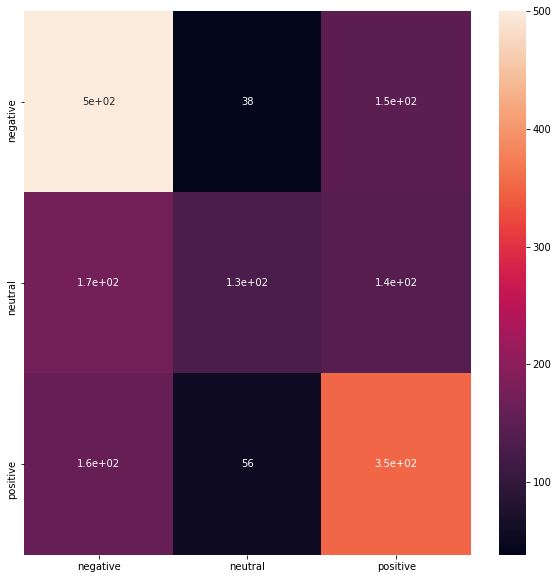

In [27]:
x_axis_labels = ['negative','neutral','positive']
y_axis_labels = ['negative','neutral','positive']

plt.figure(figsize=(10,10))

sns.heatmap(confusion_matrix(y_test_bow_cm,final_pred_bow, labels=['negative','neutral','positive']),annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)

### Insights Drawn

- from the confusion matrix for the test dataset with 1699 data points, we can see that:

    - 500: true negative

    - 350: true positive 

## 2/ TF-IDF Approach

In [29]:
# create the transform
vectorizer_tfidf = TfidfVectorizer()

# tokenize and build vocab
vectorizer_tfidf.fit(tweet_text)

# review vocab 
# print(vectorizer_tfidf.vocabulary_)
print(len(vectorizer_tfidf.vocabulary_))

# review the idf 
print(vectorizer_tfidf.idf_)
print(len(vectorizer_tfidf.idf_))

# encode all tweets 
vector_tfidf = vectorizer_tfidf.transform(tweet_text)

# summarize encoded vector
print(vector_tfidf.shape)
print(vector_tfidf.toarray().shape)
print(type(vector_tfidf.toarray()))

16415
[8.10120516 8.10120516 9.35396813 ... 7.96767377 9.35396813 8.66082095]
16415
(8493, 16415)
(8493, 16415)
<class 'numpy.ndarray'>


## 3/ Hashed Vectorization Approach

In [ ]:
# create the transform
vectorizer_hv = HashingVectorizer(n_features=20)

# encode document
vector_hv = vectorizer_hv.transform(tweet_text)

# summarize encoded vector
print(vector_hv.shape)
print(vector_hv.toarray())
print(vector_hv.toarray().shape)

## Pre-processing

#### Train-Test Split

In [ ]:
# split into train test sets
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(tweet_text, tweet_sentiment_labels, test_size=0.20, random_state=0)

#### Explore the Train-Test Split

In [ ]:
X_train_bow.head()

In [ ]:
y_train_bow.head()

In [ ]:
X_test_bow.head()

In [ ]:
y_test_bow.head()

## Comparison

# Resources

- [How to Encode Text Data for Machine Learning with scikit-learn](https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/)

- [Sentiment Analysis of YouTube Comments](https://www.analyticssteps.com/blogs/sentiment-analysis-youtube-comments)